## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

## Dataset handling

In [2]:
df = pd.read_csv("FODS-A2.csv")
df.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,21.20,33.290,19.823333,31.790000,23.463333,38.230000,20.50,31.73,19.200000,39.363333,...,29.230000,9.85,756.183333,41.833333,4.833333,40.0,-2.67,42.017180,42.017180,290
1,21.79,38.500,19.500000,40.633333,22.500000,37.900000,21.00,37.90,20.033333,47.290000,...,40.326667,6.90,754.000000,75.000000,4.000000,40.0,2.80,24.624380,24.624380,50
2,22.39,41.390,20.200000,43.790000,24.500000,39.333333,20.10,38.26,19.390000,48.090000,...,42.060000,10.10,756.433333,68.000000,5.833333,40.0,4.45,3.731260,3.731260,260
3,24.00,30.260,24.390000,26.963333,23.390000,33.400000,22.79,31.20,21.033333,40.626667,...,35.500000,19.10,760.000000,31.000000,4.000000,40.0,1.50,1.058826,1.058826,50
4,20.05,38.245,17.600000,41.000000,21.100000,37.200000,19.89,36.40,18.200000,43.560000,...,38.863333,0.10,754.600000,99.000000,1.000000,32.0,-0.10,39.248108,39.248108,30


In [3]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## Feature Selection using Pearson Coefficient

In [4]:
y  = df['Appliances'].to_numpy().T
df1 = df.drop('Appliances', axis = 1).to_numpy().T

In [5]:
df1.shape[0]

26

In [6]:
pearsonCoeff = []
for i in range(df1.shape[0]):
    pearsonCoeff.append(abs(np.corrcoef(df1[i], y)[0][1]))

In [7]:
pearsonCoeff = pd.DataFrame(pearsonCoeff, columns = ['Absolute Pearson Correlation Coeff'])
pearsonCoeff['Feature'] = df.drop('Appliances', axis = 1).columns

In [8]:
pearsonCoeff = pearsonCoeff.sort_values("Absolute Pearson Correlation Coeff", ascending=False)

In [9]:
pearsonCoeff

,Absolute Pearson Correlation Coeff,Feature
20,0.157888,RH_out
10,0.115799,T6
2,0.109542,T2
18,0.098908,T_out
15,0.091040,RH_8
21,0.090048,Windspeed
11,0.083081,RH_6
4,0.080892,T3
1,0.076796,RH_1
3,0.066223,RH_2


In [10]:
set1 = []
for i in range(df1.shape[0]):
    s = []
    for j in range(i+1):
        s.append(pearsonCoeff.iloc[j].Feature)
    set1.append(np.array(s))

In [11]:
print(len(set1))
set1 = np.array(set1)

26


/var/folders/9c/_mcnftr9327fc2k3mqf4cdh80000gn/T/ipykernel_14398/1275599385.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  set1 = np.array(set1)


## Feature Selection using PCA

In [12]:
def pcatransform(x, dim):
    y  = x['Appliances']
    x = x.drop('Appliances', axis = 1)
    pca = PCA(n_components = dim)
    x_pca = pca.fit_transform(x)
    x_pca = pd.DataFrame(x_pca, columns = pca.get_feature_names_out())
    x_pca['Appliances'] = y
    variance = pca.explained_variance_ratio_.cumsum()[-1]
    variance *= 100
    return x_pca, variance

## Functions for regression

In [13]:
def split(df):
    # Shuffling the dataset
    shuffled_df = df.sample(frac=1, random_state=100)

    # Define a size for your train set
    training_data_size = int(0.8 * len(df))

    # Split your dataset
    training_data = shuffled_df[:training_data_size]
    testing_data = shuffled_df[training_data_size:]
    
    X_train = training_data.drop(['Appliances'], axis=1)
    X_test = testing_data.drop(['Appliances'], axis=1)
    y_train = training_data["Appliances"].to_numpy().T
    y_test = testing_data["Appliances"].to_numpy().T
    
    return X_train, X_test, y_train, y_test

In [14]:
def batchnorm(X_train, X_test):
    mean = X_train.mean()
    stddev = X_train.std()
    X_train = (X_train - mean) / stddev
    X_test = (X_test - mean) / stddev
    X_train.to_numpy()
    X_test.to_numpy()
    return X_train, X_test

In [15]:
def initialize(dim):
    np.random.seed(42)
    b = random.random()
    theta = np.random.rand(1, dim) * 0.01
    return b, theta

In [16]:
def gradient_descent(num_epochs, X, t, theta, bias, lr):
    # forward-prop
    costs = []
    for iter in range(num_epochs):
        y = np.dot(theta, X.T) + bias

        loss = get_cost(y, t)
        # print(loss)
        costs.append(loss)

        # backprop
        der = (1 / y.shape[1]) * np.dot(y - t, X)
        dBias = (1 / y.shape[1]) * np.sum((y - t))

        # updation
        theta = theta - lr * der
        bias = bias - lr * dBias

    return costs,theta,bias

In [17]:
def get_cost(y, t):
    return 0.5 * np.sum(np.power((t - y), 2)) / y.shape[1]

In [18]:
def fwd_prop_test(X, y_test, theta, bias):
    y = np.dot(theta, X.T) + bias
    loss = get_cost(y, y_test)
    return loss

In [19]:
def batch_gd_pearson(dim, num_epochs, learning_rate):
    data = df[np.append(set1[dim-1], 'Appliances')]
    X_train, X_test, y_train, y_test = split(data)
    X_train, X_test = batchnorm(X_train, X_test)
    bias, weights = initialize(dim)
    BGD_MSE_train,weights,bias = gradient_descent(
        num_epochs, X_train, y_train, weights, bias, learning_rate
    )
    plt.plot(BGD_MSE_train)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title("LOSS CURVE")
    plt.show()
    #plt.savefig('Training error for BGD degree {}.png'.format(degree))
    BGD_mse_test = fwd_prop_test(X_test, y_test, weights, bias)
    return BGD_mse_test, BGD_MSE_train[-1], bias, weights

In [20]:
def batch_gd_pca(dim, num_epochs, learning_rate):
    data_pca, variance = pcatransform(df, dim)
    X_train, X_test, y_train, y_test = split(data_pca)
    X_train, X_test = batchnorm(X_train, X_test)
    bias, weights = initialize(dim)
    BGD_MSE_train,weights,bias = gradient_descent(
        num_epochs, X_train, y_train, weights, bias, learning_rate
    )
    plt.plot(BGD_MSE_train)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title("LOSS CURVE")
    plt.show()
    #plt.savefig('Training error for BGD degree {}.png'.format(degree))
    BGD_mse_test = fwd_prop_test(X_test, y_test, weights, bias)
    return BGD_mse_test, BGD_MSE_train[-1], bias, weights, variance

## Regression after Pearson Coefficient Feature Selection

In [21]:
test_mse_arr1 = []
train_mse_arr1 = []
bias_arr1 = []
weights_arr1 = []

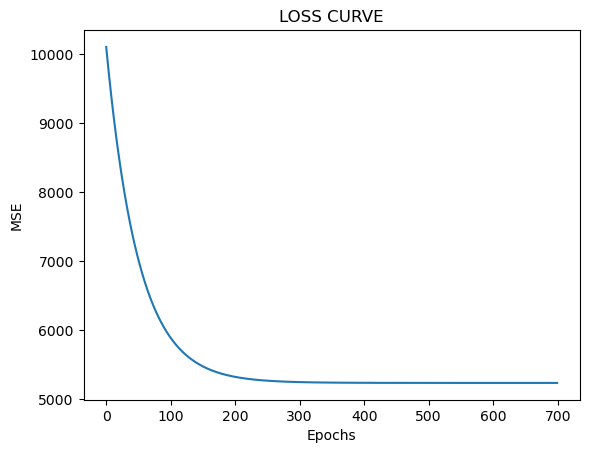

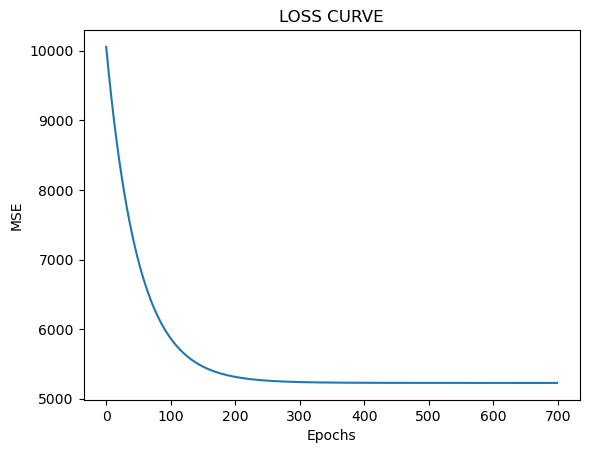

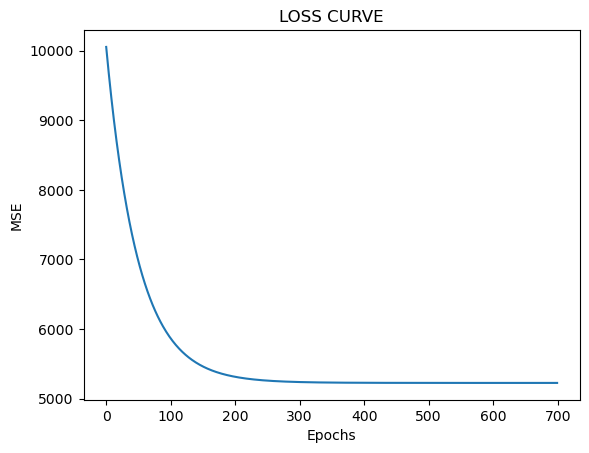

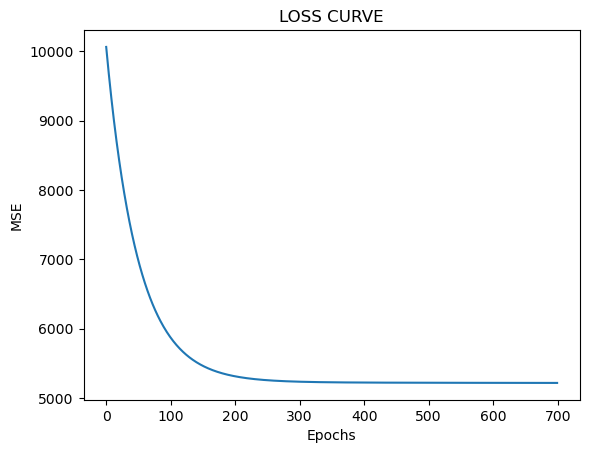

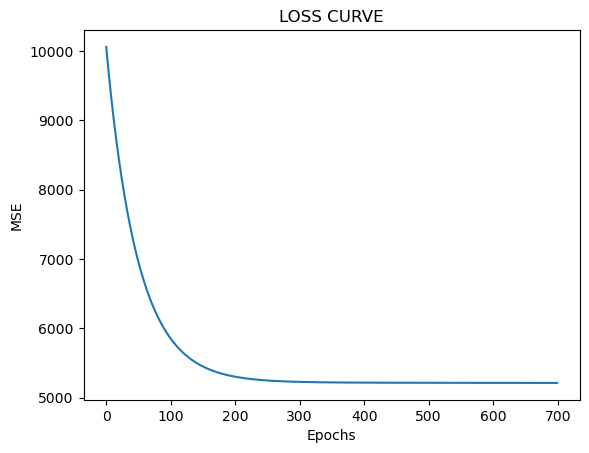

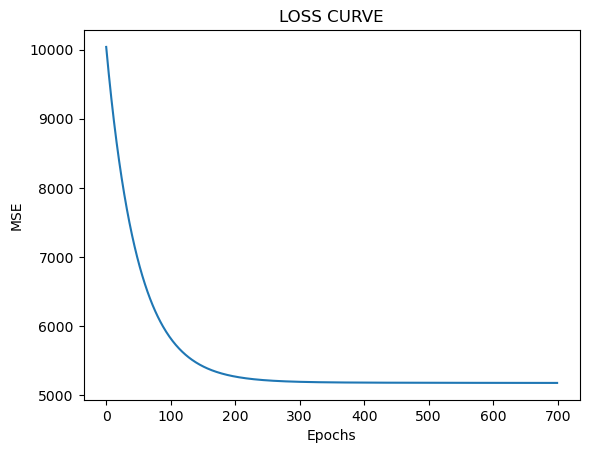

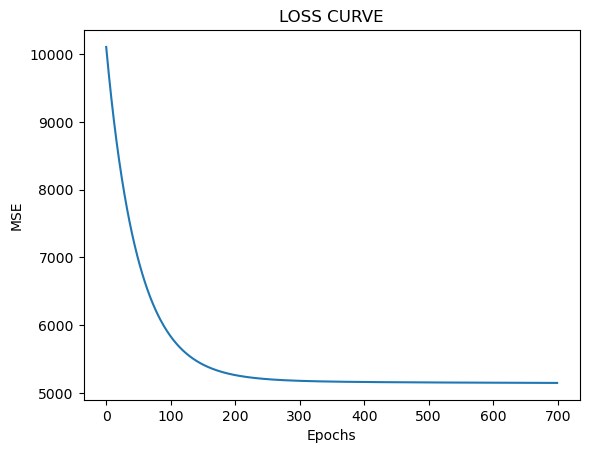

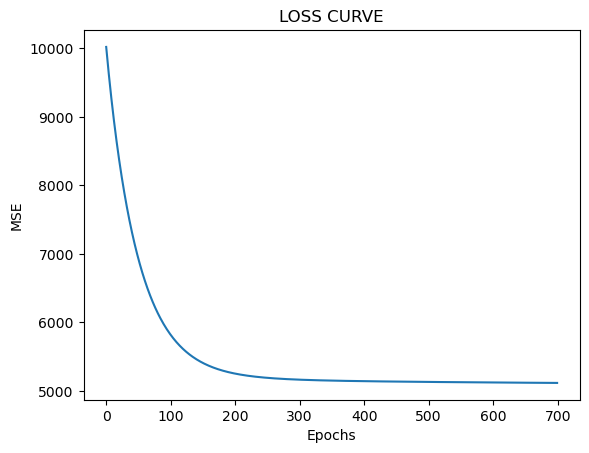

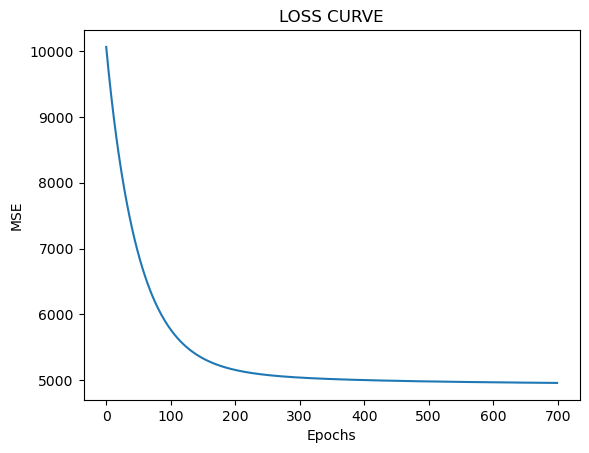

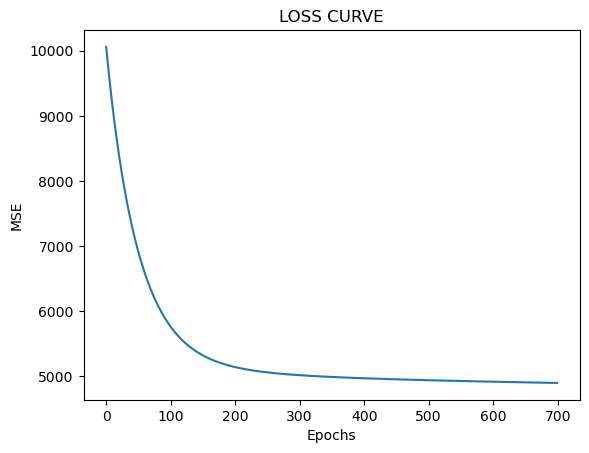

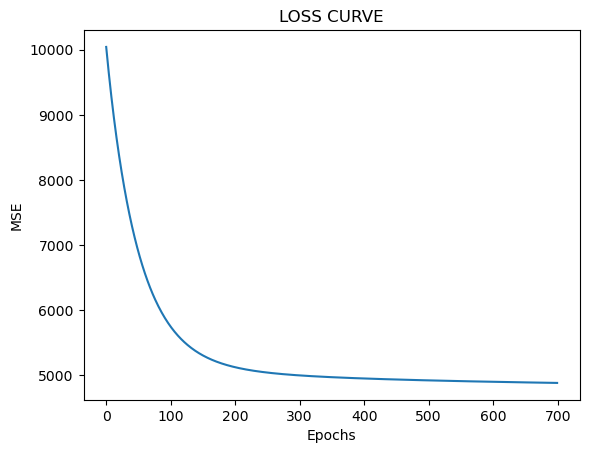

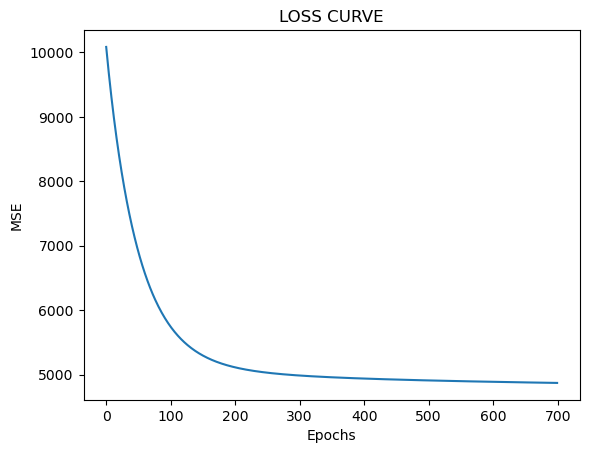

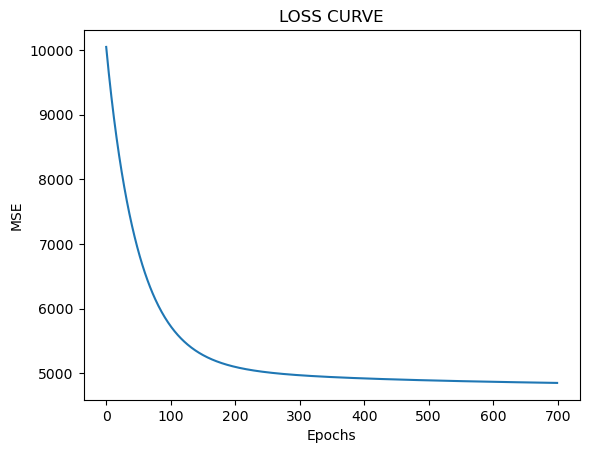

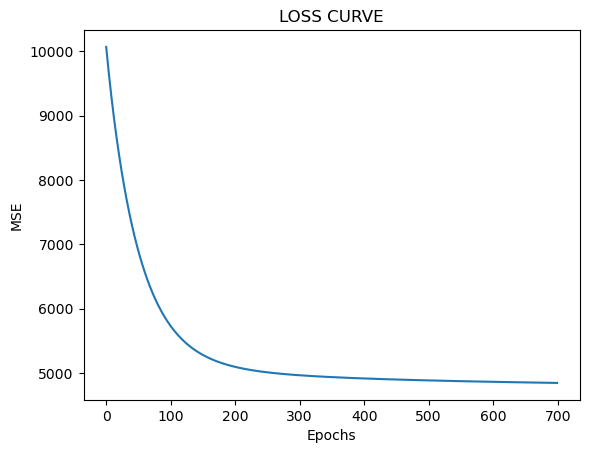

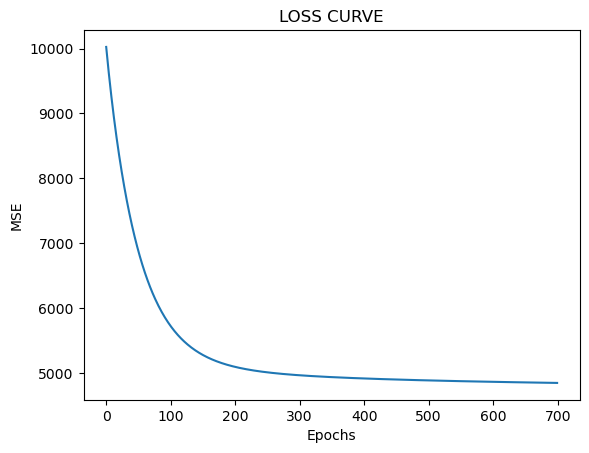

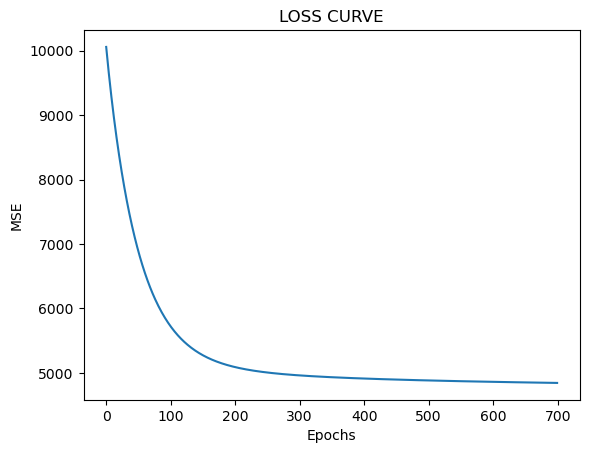

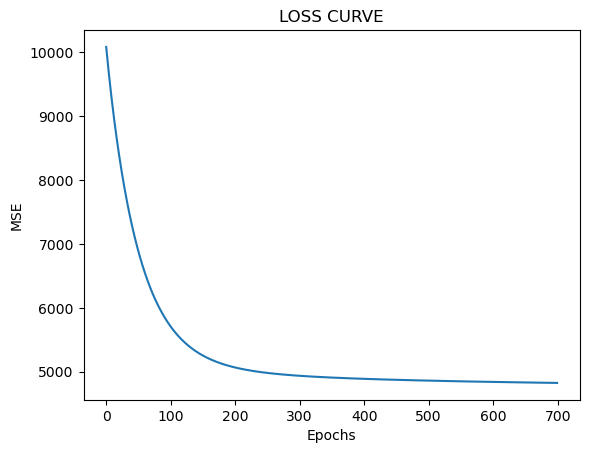

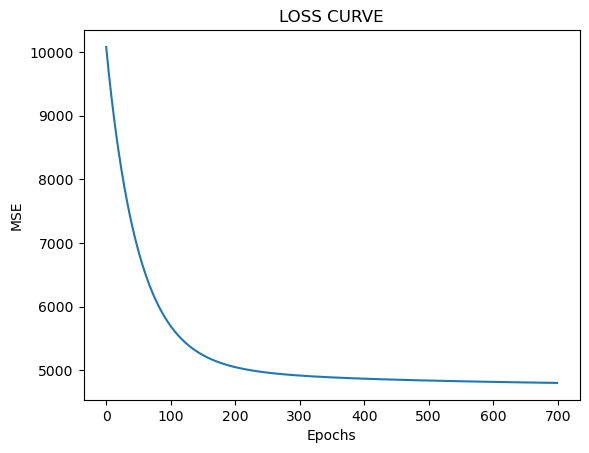

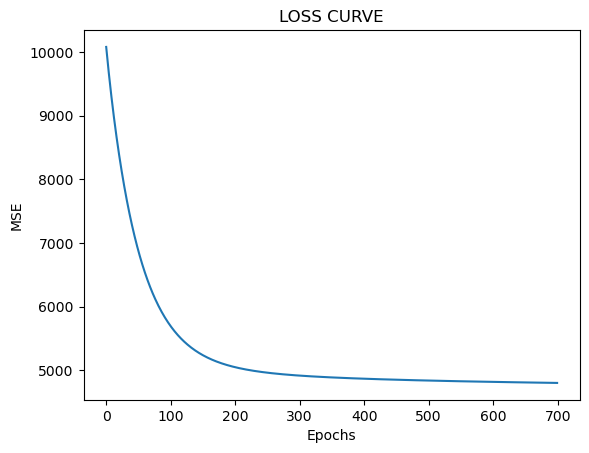

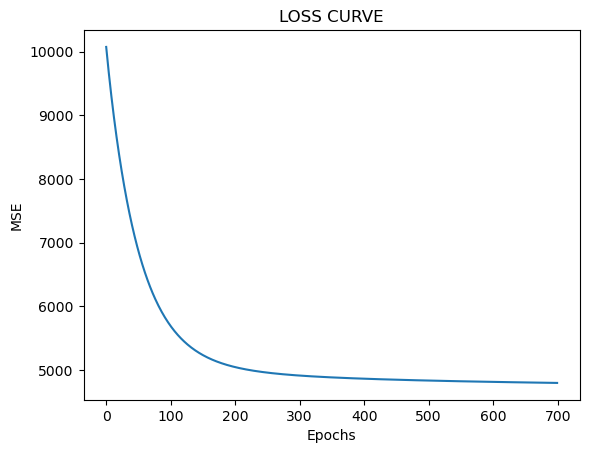

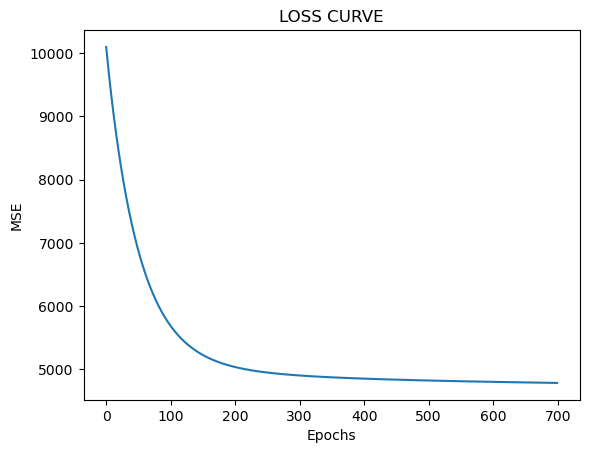

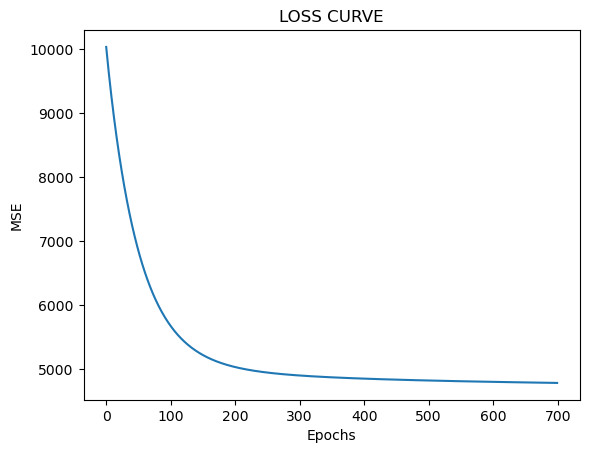

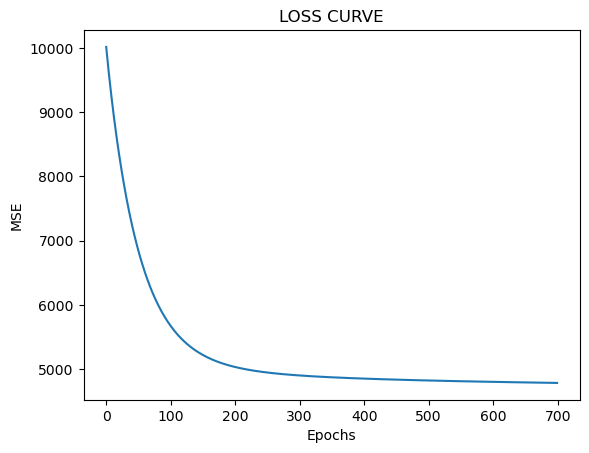

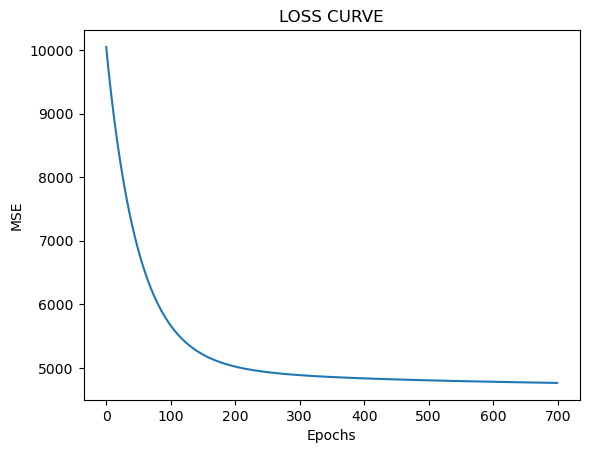

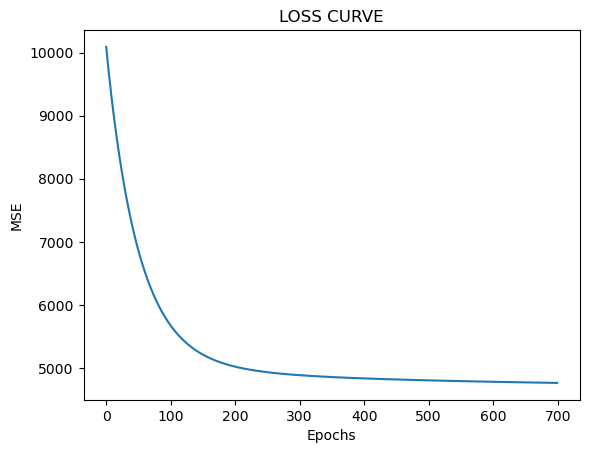

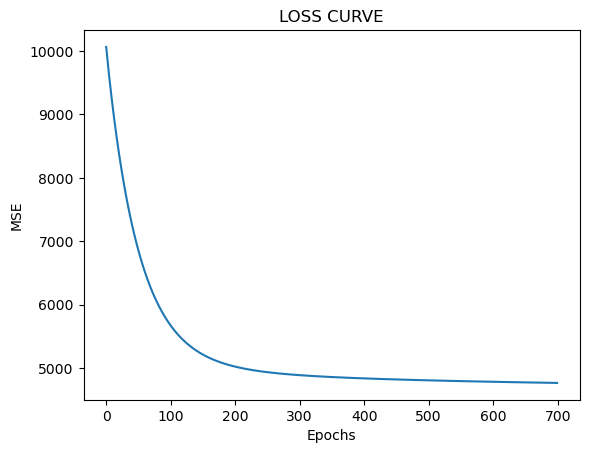

In [22]:
for i in range(26):
    test_mse, train_mse, bias, weights = batch_gd_pearson(i+1, 700, 0.01)
    train_mse_arr1.append(train_mse)
    test_mse_arr1.append(test_mse)
    weights_arr1.append(weights)
    bias_arr1.append(bias)

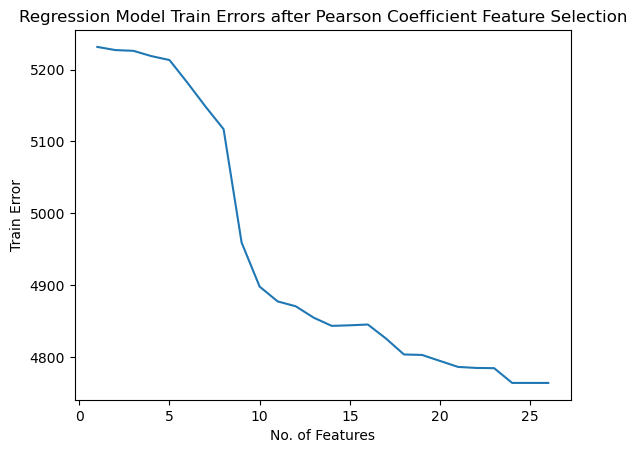

In [23]:
train_mse_arr1 = pd.DataFrame(train_mse_arr1, columns = ['Train MSE'])
train_mse_arr1.index +=1
plt.plot(train_mse_arr1)
plt.xlabel("No. of Features") 
plt.ylabel("Train Error") 
plt.title("Regression Model Train Errors after Pearson Coefficient Feature Selection") 
plt.savefig('Graphs/1train.jpg')
plt.show()

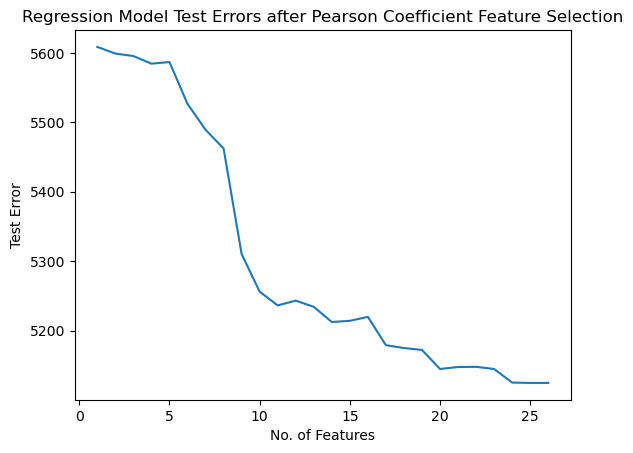

In [24]:
test_mse_arr1 = pd.DataFrame(test_mse_arr1, columns = ['Test MSE'])
test_mse_arr1.index +=1
plt.plot(test_mse_arr1)
plt.xlabel("No. of Features") 
plt.ylabel("Test Error") 
plt.title("Regression Model Test Errors after Pearson Coefficient Feature Selection") 
plt.savefig('Graphs/1test.jpg')
plt.show()

In [25]:
print("no. of features for minimum test error =", test_mse_arr1.idxmin()[0])
print("no. of features for minimum train error =", train_mse_arr1.idxmin()[0])

no. of features for minimum test error = 26
no. of features for minimum train error = 25


In [26]:
pd.concat([train_mse_arr1, test_mse_arr1], axis=1, join='inner')

,Train MSE,Test MSE
1,5231.579176,5608.494532
2,5227.189962,5598.944665
3,5226.135975,5595.359307
4,5218.753252,5584.399922
5,5213.326798,5586.692238
6,5181.597282,5526.516355
7,5148.424783,5489.187180
8,5117.056759,5462.247270
9,4959.100045,5310.348965
10,4897.697399,5256.034418


## Regression after PCA

In [27]:
test_mse_arr2 = []
train_mse_arr2 = []
bias_arr2 = []
weights_arr2 = []
var = []

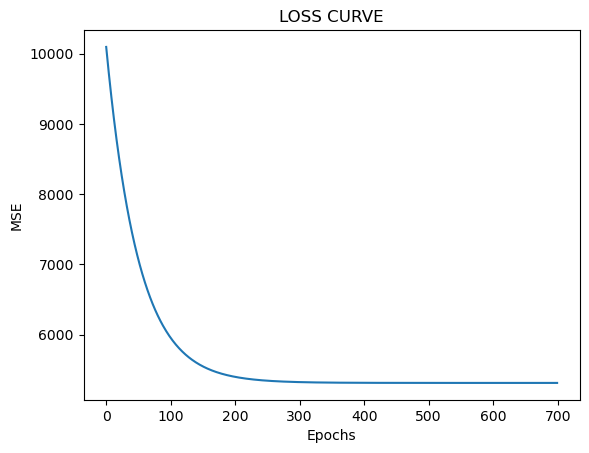

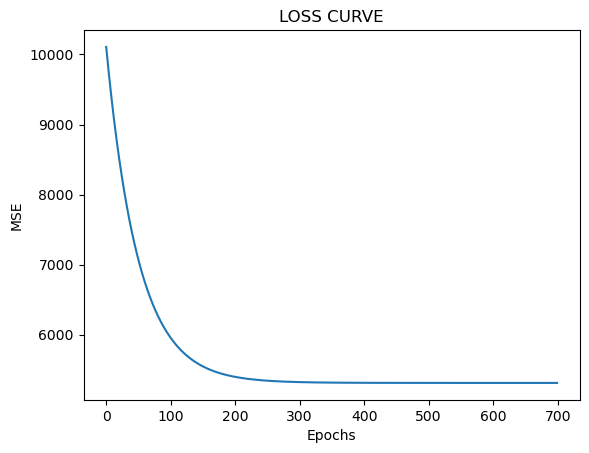

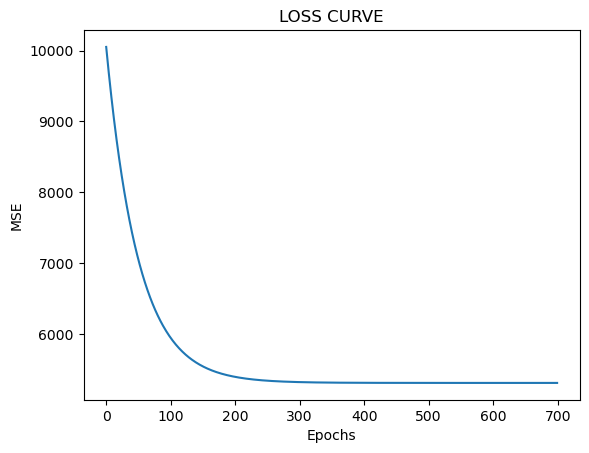

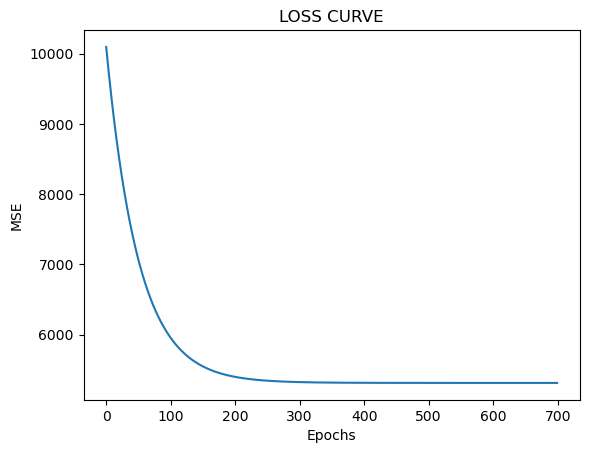

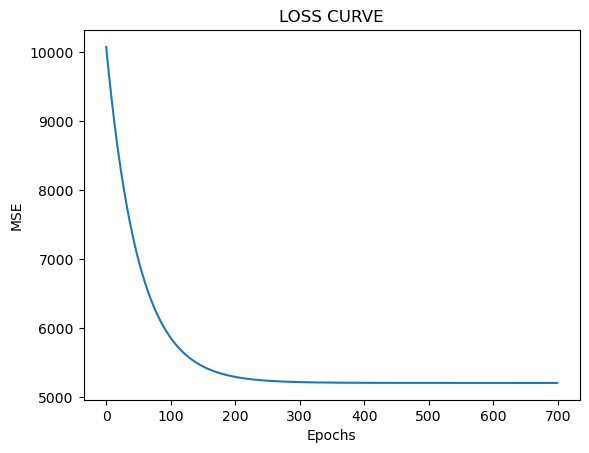

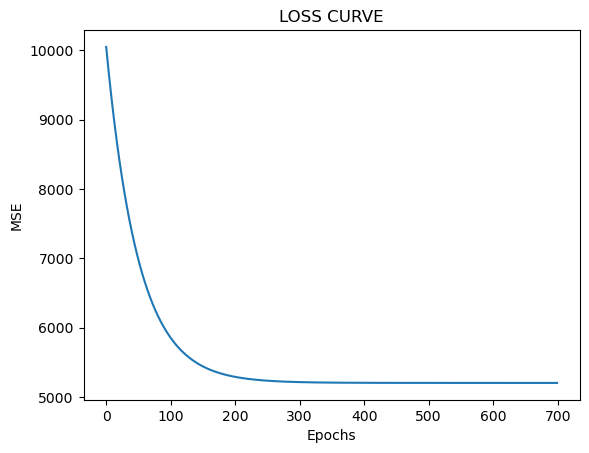

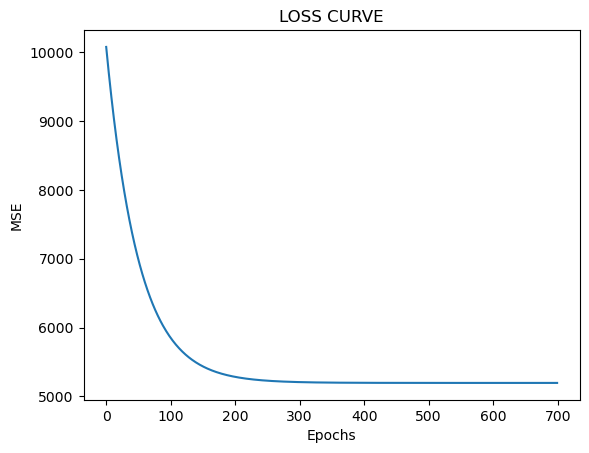

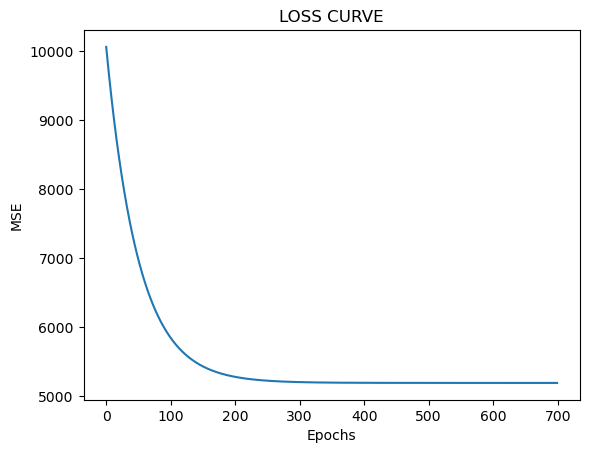

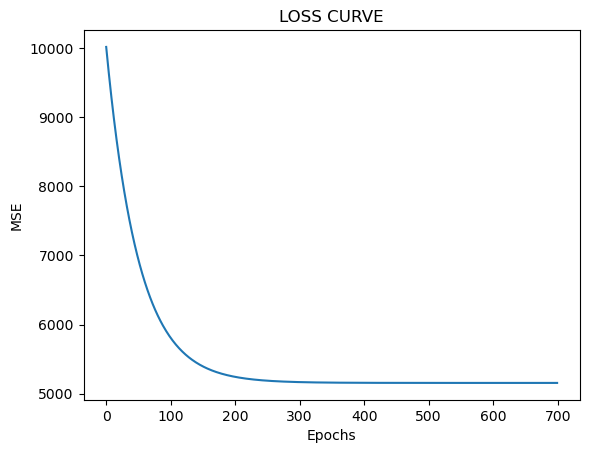

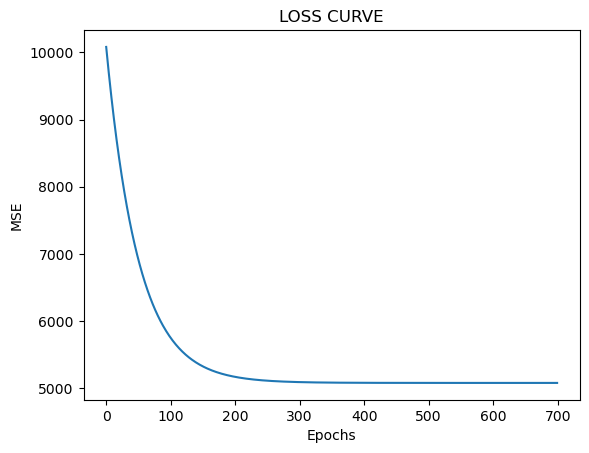

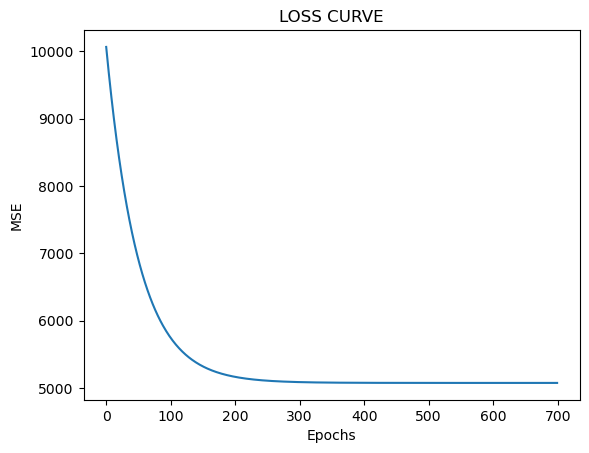

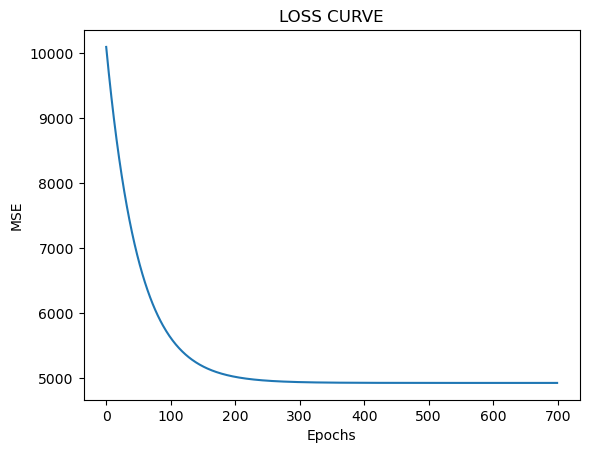

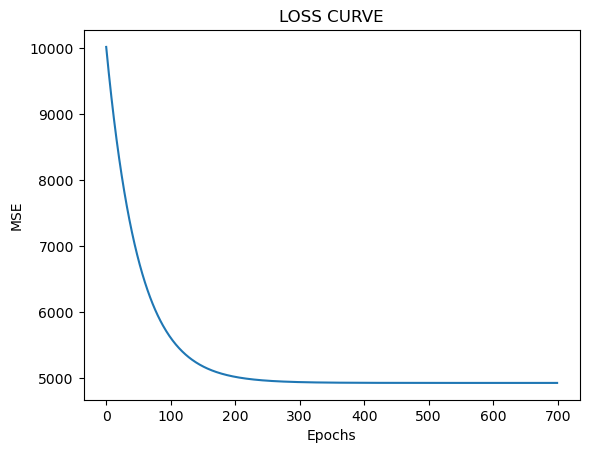

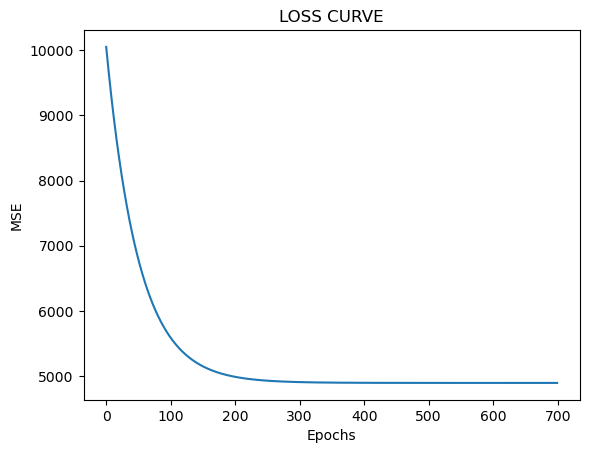

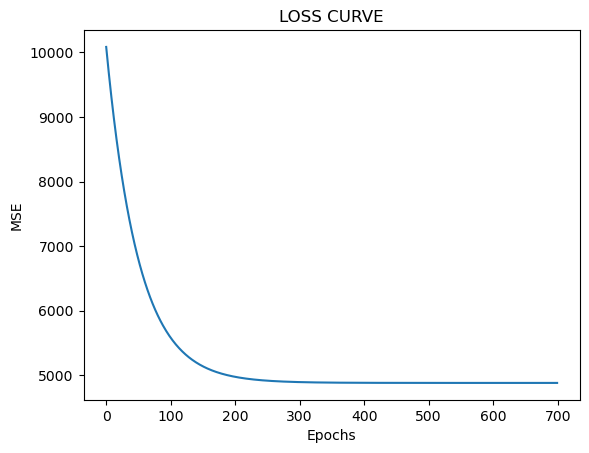

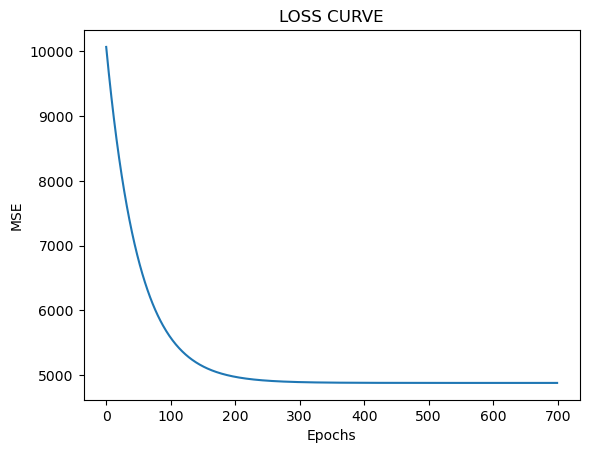

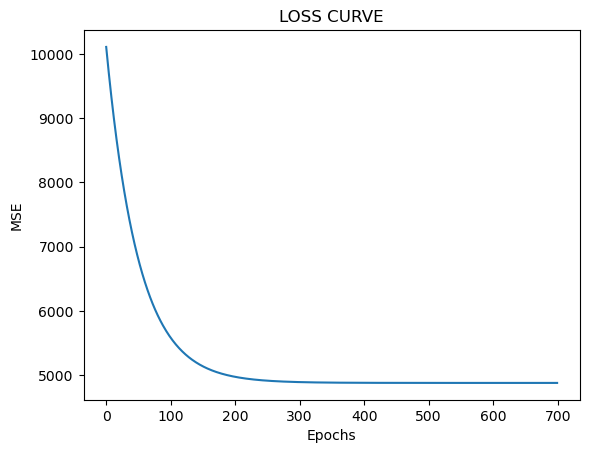

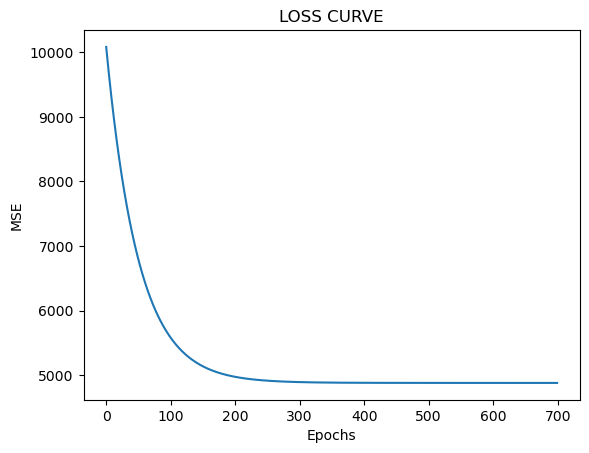

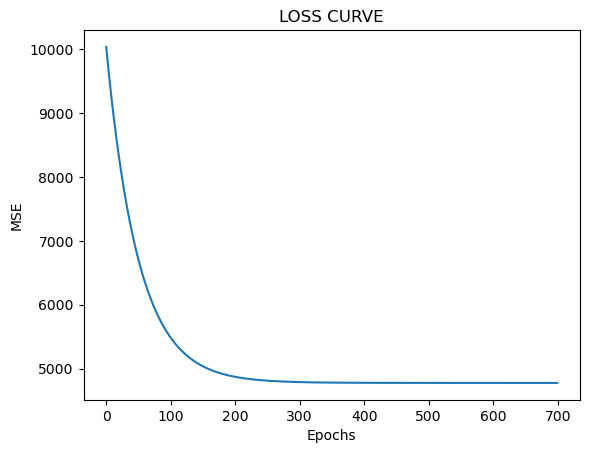

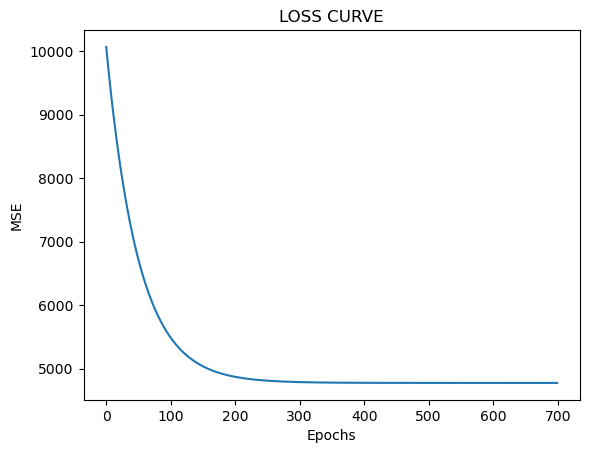

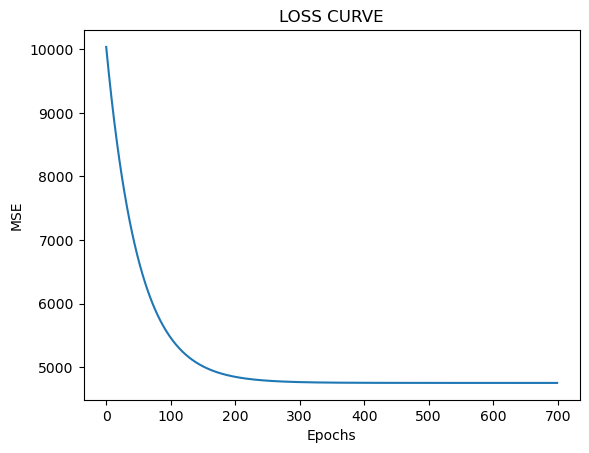

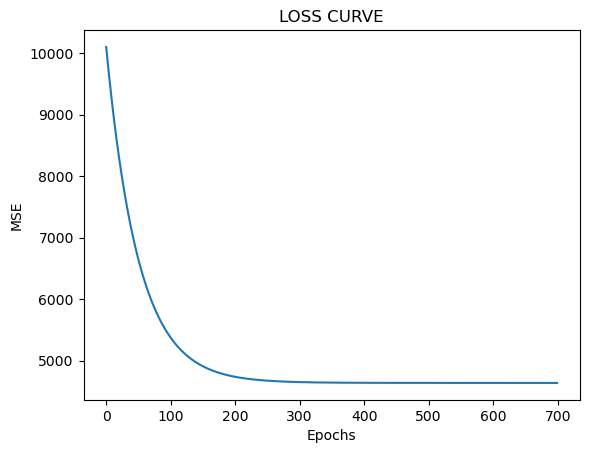

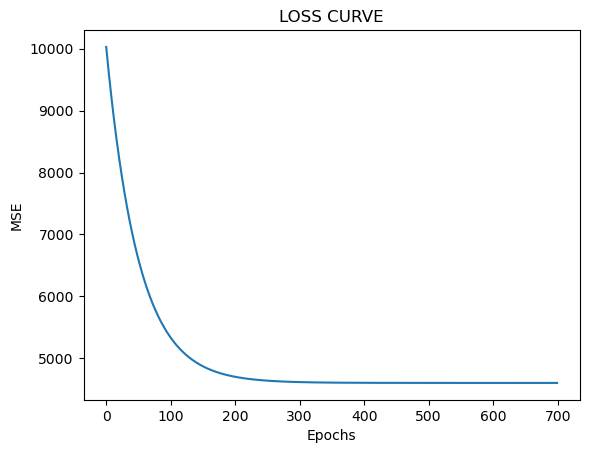

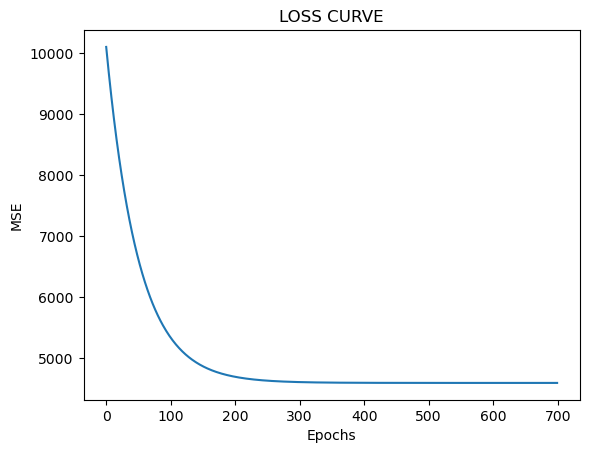

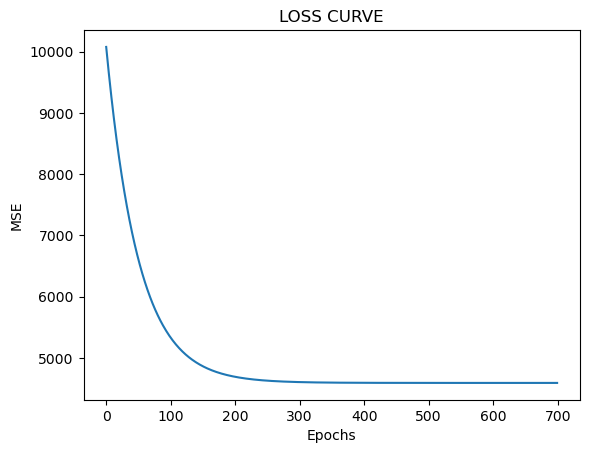

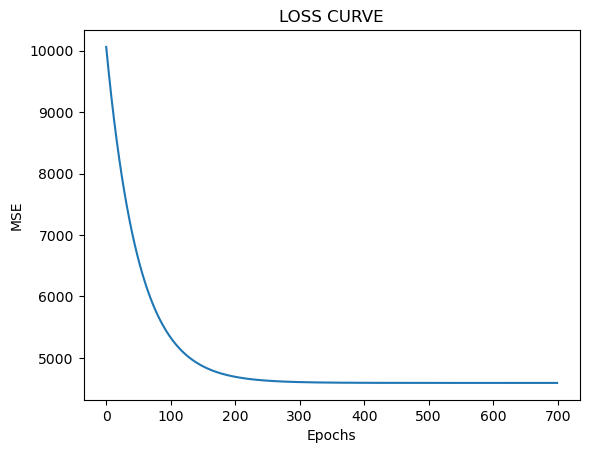

In [28]:
for i in range(26):
    test_mse, train_mse, bias, weights, variance = batch_gd_pca(i+1, 700, 0.01)
    train_mse_arr2.append(train_mse)
    test_mse_arr2.append(test_mse)
    weights_arr2.append(weights)
    bias_arr2.append(bias)
    var.append(variance)

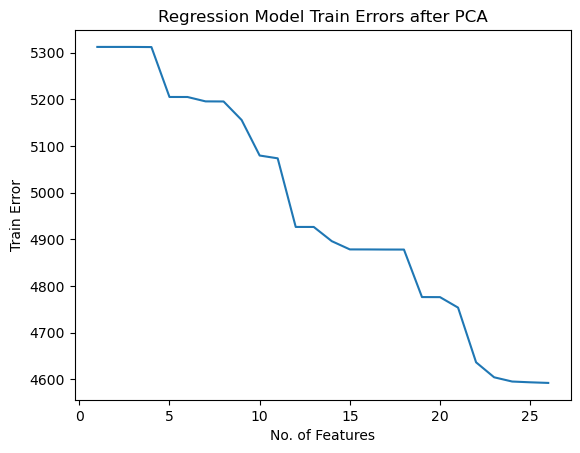

In [29]:
train_mse_arr2 = pd.DataFrame(train_mse_arr2, columns = ['Train MSE'])
train_mse_arr2.index +=1
plt.plot(train_mse_arr2)
plt.xlabel("No. of Features") 
plt.ylabel("Train Error") 
plt.title("Regression Model Train Errors after PCA") 
plt.savefig('Graphs/2train.jpg')
plt.show()

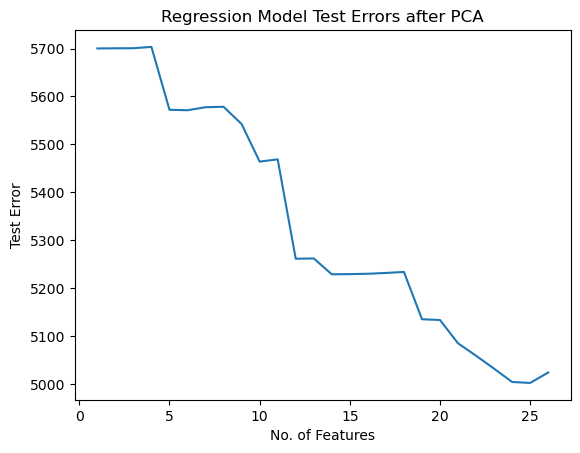

In [30]:
test_mse_arr2 = pd.DataFrame(test_mse_arr2, columns = ['Test MSE'])
test_mse_arr2.index +=1
plt.plot(test_mse_arr2)
plt.xlabel("No. of Features") 
plt.ylabel("Test Error") 
plt.title("Regression Model Test Errors after PCA") 
plt.savefig('Graphs/2test.jpg')
plt.show()

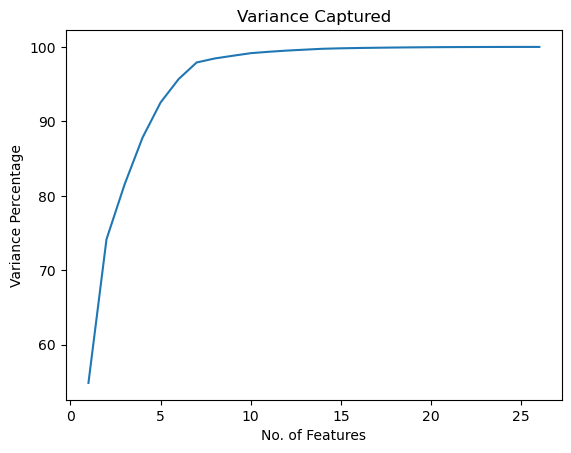

In [31]:
var = pd.DataFrame(var, columns = ['Variance %'])
var.index +=1
plt.plot(var)
plt.xlabel("No. of Features") 
plt.ylabel("Variance Percentage") 
plt.title("Variance Captured") 
plt.savefig('Graphs/2var.jpg')
plt.show()

In [32]:
var

,Variance %
1,54.873114
2,74.154423
3,81.507516
4,87.823240
5,92.539805
6,95.680140
7,97.913318
8,98.449016
9,98.811890
10,99.161085


In [33]:
print("no. of features for minimum test error =", test_mse_arr2.idxmin()[0])
print("no. of features for minimum train error =", train_mse_arr2.idxmin()[0])
print("no. of features for max variance captured =", var.idxmax()[0])

no. of features for minimum test error = 25
no. of features for minimum train error = 26
no. of features for max variance captured = 25


In [34]:
pd.concat([train_mse_arr2, test_mse_arr2, var], axis=1, join='inner')

,Train MSE,Test MSE,Variance %
1,5312.286313,5700.101033,54.873114
2,5312.273180,5700.469091,74.154423
3,5312.258428,5700.618263,81.507516
4,5311.972245,5703.323313,87.823240
5,5204.986907,5572.233372,92.539805
6,5204.940810,5571.237038,95.680140
7,5195.553055,5577.597569,97.913318
8,5195.350409,5578.423315,98.449016
9,5155.670259,5542.460464,98.811890
10,5079.480682,5464.112299,99.161085
